Harika—SOM (Self-Organizing Maps) sezgisi tam bu başlıkların sırasıyla öğrenilecek türden. Aşağıya hem “neden/ nasıl çalışır” çekirdeğini hem de K-Means bağlantısını pratik mühendis gözüyle özetledim.

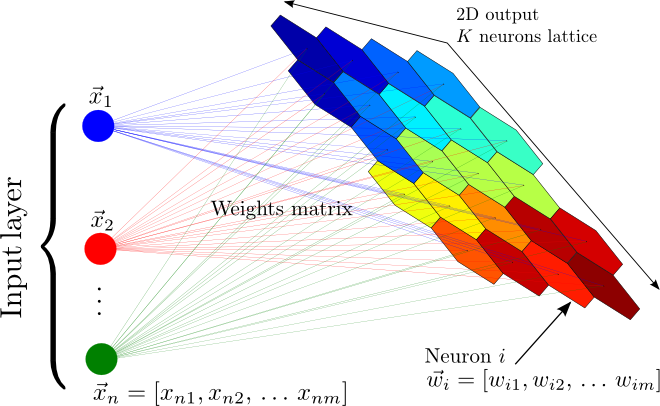


# SOM nedir, ne işe yarar?

* **Denetimsiz** (labelsız) bir yöntemdir; yüksek boyutlu veriyi **2D bir ızgaraya** “topolojiyi koruyarak” yansıtır.
* Amaç: **Benzer örnekler birbirine yakın hücrelere** (nöronlara) düşsün → kümeler, sınırlar, aykırılıklar görsel olarak ortaya çıksın.
* Klasik indirgeme (PCA) doğrusal ilişkileri korur; **SOM doğrusal olmayan yapıları** ve **komşuluğu** (topoloji) korumada iyidir.

# SOM nasıl çalışır? (çekirdek algoritma)

Grid: $M \times N$ nöron. Her nöronun bir **ağırlık vektörü** $\mathbf{w}_i \in \mathbb{R}^d$ (codebook/prototype) vardır.

1. **Başlat**: $\mathbf{w}_i$’leri küçük rastgele değerlerle (ya da PCA ile) başlat.
2. Her örnek için $\mathbf{x}$:

   * **BMU’yu bul** (Best Matching Unit):

     $$
     c = \arg\min_i \|\mathbf{x} - \mathbf{w}_i\|
     $$
   * **Komşuları güncelle** (kazanan + komşuları “çekilir”):

     $$
     \mathbf{w}_i \leftarrow \mathbf{w}_i + \alpha(t)\, h_{ci}(t)\,(\mathbf{x} - \mathbf{w}_i)
     $$

     Burada $h_{ci}(t)$ genelde Gauss komşuluğu:

     $$
     h_{ci}(t)=\exp\!\Big(-\frac{\|\mathbf{r}_c-\mathbf{r}_i\|^2}{2\,\sigma(t)^2}\Big)
     $$

     $\alpha(t)$ (öğrenme oranı) ve $\sigma(t)$ (komşuluk yarıçapı) **zamanla azalır**.
3. Çok sayıda epoch boyunca tekrarla → grid “veriye uyar”.

**Sonuç:** Her nöron bir “kümenin temsilcisi” gibi konumlanır; benzer örnekler aynı bölgelere düşer.



# SOM ve boyut indirgeme

* **Çıkış:** 2D grid. Her hücreye düşen örnek sayısı/dağılımı, aradaki mesafeler, **U-Matrix** (komşu prototipler arası mesafe ısı haritası) ile görselleştirilir:

  * Koyu/ışık “duvarlar” = **küme sınırları**,
  * Yüksek mesafeli tekil adacıklar = **aykırılar** (anomaliler).
* **Component planes**: Her özelliğin grid üzerindeki dağılımı → hangi özellik hangi kümeyi ayırıyor görürsün.

# SOM ↔ K-Means ilişkisi (neden K-Means önemli?)

* **Benzerlik:** Her ikisi de **vektör nicemleme** yapar (veriyi prototiplere atama).
* **Fark:** K-Means’te **sadece kazanan merkez** güncellenir; SOM’da **kazananın komşuları da** güncellenir → **topolojik düzen** ve pürüzsüzlük oluşur.
* **Sonradan K-Means:** SOM prototiplerini (codebook) alıp **K-Means ile gruplarsın** → grid üstünde “büyük kümeler” etiketlenir/lokalleştirilir.
* **Kötü başlatma tuzağı:** K-Means rastgele başlatılırsa kötü yerel minima. **k-means++** kullan → daha iyi ve hızlı yakınsama.
* **Elbow (WCSS)**: $k$ seçiminde **iç küme kare hatası** (Within-Cluster Sum of Squares) eğrisinde “dirsek” noktası optimum $k$’yı önerir (Silhouette skoru da kullanılabilir).

# Adım adım SOM uygulama akışı (pratik)

1. **Ön işleme**

   * Eksikleri temizle, kategorikleri encode et; **özellikleri ölçekle** (std/MinMax).
   * Ağırlıklandırma gerekiyorsa alan bilgisiyle feature scaling uygula.
2. **Grid boyutu**

   * Kural-of-thumb: nöron sayısı $\approx 5\sqrt{N}$ (N=örnek sayısı) veya $M\!\times\!N \in [\sqrt{5N}, 10\sqrt{N}]$.
3. **Hiperparametreler**

   * $ \alpha_0 \sim 0.5 \rightarrow 0.01$ arası azalsın.
   * $\sigma_0$ başlangıçta grid boyutunun \~yarısı, zamanla azalır.
   * **Epoch**: veri boyutuna göre 100–1000+ (online/batch SOM).
4. **Eğit** → BMU bul, komşuları güncelle, $\alpha$ ve $\sigma$ azalt.
5. **Değerlendir**

   * **Quantization Error (QE)**: $\frac{1}{N}\sum \|\mathbf{x}-\mathbf{w}_{BMU}\|$ (ne kadar iyi nicemlendi?)
   * **Topographic Error (TE)**: komşuluk korunumu (BMU ve ikinci BMU komşu mu?).
6. **Yorumla / Kullan**

   * **U-Matrix** → kümeler/sınırlar.
   * **Component planes** → hangi özellik ayırıyor.
   * **Aykırı tespit**: BMU mesafesi yüksek olanlar, seyrek bölgeler.
   * **K-Means** ile prototipleri kümele & etiketle (isteğe bağlı).

# SOM vs PCA / t-SNE / UMAP (kısa)

* **PCA**: hızlı, doğrusal; topoloji koruması sınırlı.
* **t-SNE/UMAP**: kümeleri iyi ayırır ama **global mesafeler** zor yorumlanır; harita **stabilitesi** ayarlara duyarlı olabilir.
* **SOM**: grid üzerinde **topoloji+yorumlanabilirlik** (U-Matrix, component planes); aynı zamanda **prototipler** elde edersin (sonraki denetimli aşamalar için faydalı).

# Anomali / fraud gibi alanlarda nasıl kullanırsın?

* Her varlık için (müşteri, cihaz, hatta senin projendeki “kişi/seyahat/otel” kompozit featur’ları) bir **özellik vektörü** çıkar.
* SOM’u eğit → **yüksek QE** veya **U-Matrix’te sınırda/yalıtık** düşenler = **şüpheli/aykırı**.
* Prototipleri **K-Means** ile kümele → anlamlı segmentler (örn. “normal iş seyahati” vs “şüpheli yoğun bağlantılı seyahat”).
* Bu etiketleri denetimli modellerine **weak label** olarak da besleyebilirsin.

# Dikkat / İpuçları

* **Ölçekleme şart.** Farklı skala, SOM’u yanıltır.
* Grid **çok küçük** → aşırı sıkışma; **çok büyük** → aşırı pürüz, boş hücreler.
* **Özellik seçimi** kritik: gürültülü/kollinear özellikler grid’i dağıtır (gerekirse PCA öncesi).
* **Mesafe ölçütü** genelde Öklid; farklı veri tiplerinde (örn. ikili/categorical) uygun temsiller/mesafeler kullan.

---

Kısa ve net: **SOM (Self-Organizing Map)**, etiket (label) olmadan **yüksek boyutlu veriyi 2D bir haritaya** yerleştirip **benzer örnekleri yakın**, **farklıları uzak** konumlandıran bir **denetimsiz öğrenme** tekniğidir. Bu sayede verinin yapısını görür, kümeleri ve aykırıları keşfedersin.

## SOM ne amaçla kullanılır?

* **Boyut indirgeme & görselleştirme:** Yüksek boyutlu veriyi 2D grid’e indirerek **kümeleri, sınırları, geçiş bölgelerini** görsel olarak ortaya çıkarır (U-Matrix, component planes).
* **Keşifsel kümeleme / segmentasyon:** Grid üzerindeki bölgeler doğal **segmentler** oluşturur. İstersen kodbook (prototip) vektörlerini **K-Means** ile sonradan gruplarsın.
* **Prototip öğrenme (vector quantization):** Her hücre bir **temsil vektörü** (codebook) öğrenir. Bunlar:

  * Veri **sıkıştırma** / özetleme,
  * **Hızlı yakın komşu** arama (coarse-to-fine),
  * Sonraki denetimli modellere **özellik/etiket** (cluster id) olarak besleme için kullanılır.
* **Anomali/novelty tespiti:** BMU (en iyi eşleşen nöron) mesafesi **yüksek** olan örnekler, U-Matrix’te **yalıtık** veya **sınır** bölgelerine düşenler genelde **aykırı**dır.
* **Özellik analizi (feature insight):** Component plane’ler ile **hangi özelliklerin** hangi kümeleri ayırdığını görürsün → **özellik seçimi/ölçekleme** kararları.
* **K-Means’e iyi başlangıç:** SOM prototipleri, K-Means için **sağlam başlangıç merkezleri** olarak kullanılabilir (rastgele başlatma tuzağını azaltır).
* **Topoloji koruma:** Benzer örnekler **komşu hücrelere** düşer; kümeler arası **yumuşak geçişleri** görürsün (PCA’dan farklı olarak doğrusal olmayan yapıları da yakalar).

## Nerelerde kullanılır?

* **Müşteri segmentasyonu**, pazarlama, churn analizi
* **Fraud/Anomali**: kredi kartı, siber güvenlik, ağ trafiği, IoT sensörleri
* **Endüstriyel kalite kontrol**, süreç izleme
* **Biyoenformatik**, gen ifade verileri
* **Metin/embedding** haritalama, model davranışı analizi
* **Senin senaryon:** kişi-seyahat-otel-hudut özellik vektörleri → SOM:

  1. Veriyi ölçekle (zorunlu),
  2. SOM’u eğit (uygun grid boyutu),
  3. U-Matrix’te kümeleri/sınırları incele,
  4. **BMU mesafesi yüksek** kayıtları **şüpheli** say,
  5. Prototipleri K-Means ile grupla, cluster id’leri downstream modellere besle.

## Çıktılar & metrikler

* **BMU ataması** (her örnek hangi nörona düştü?)
* **U-Matrix ısı haritası** (komşu prototipler arası mesafe)
* **Component planes** (özellik bazında dağılım)
* **Quantization Error (QE)**: ortalama BMU mesafesi (ne kadar iyi nicemlendi?)
* **Topographic Error (TE)**: komşuluk/topoloji korunumu

## Pratik notlar

* **Ölçekleme şart** (MinMax/Standard). Farklı ölçekler SOM’u yanıltır.
* Grid çok **küçük** → aşırı sıkışma; çok **büyük** → seyrek/boş hücreler. Orta yol: \~$5\sqrt{N}$ nöron civarı (kaba kural).
* Özellik kalitesi kritik: gürültülü/kollinear özellikler grid’i dağıtır (gerekirse PCA ile ön-indirgeme).
* Karşılaştırma: **PCA** hızlı ama doğrusal; **t-SNE/UMAP** kümeleri iyi ayırır fakat global mesafeler ve stabilite sınırlı olabilir; **SOM** topoloji + yorumlanabilir **grid** ve **prototip** kazandırır.

İstersen bir sonraki adımda **MiniSom** ile hızlı bir SOM demo’su kurayım: ölçekleme → SOM eğitimi → U-Matrix & component plane görselleştirme → BMU mesafesiyle aykırı işaretleme → (opsiyonel) K-Means ile prototip kümeleme.
